<a id="top"></a>
# Tutorial Title

***

## Learning Goals
Write three to five learning goals. A learning goal should describe what a reader should know or be able to do by the end of the tutorial that they didn't know or couldn't do before.

```
By the end of this tutorial, you will:

- Use astroquery to access the HST archives
- Get familiar with Drizzlepac and the drizzle alignment technique
- Download the relevant calibration files with CRDS
- Combine images to create your very own previews of targets for future proposals, including for JWST!

```

## Introduction
This tutorial teaches us to align images between HST observations using `drizzlepac` and `tweakreg`. We learn the subtleties of combining images from different filters in a single visit, and combining multiple visits. Image aligning and stacking is crucial to make the most of the extensive Hubble archives, and are a crucial tool in preparing proposals for future observations. 

Before starting, [set up AstroConda](https://astroconda.readthedocs.io/en/latest/installation.html). 

## Imports
Describe the libraries we're using here. If there's something unusual, explain what the library is, and why we need it.
- *numpy* to handle array functions
- *astropy.io fits* for accessing FITS files
- *astropy.table Table* for creating tidy tables of the data
- *matplotlib.pyplot* for plotting data
- *astroquery* for pulling data from the Mikulski Archive at Space Telescope (MAST)
- *stwcs* for tracking the World Coordinate System (WCS) data in the image files
- *subprocess* to parallelize tasks
- *shutil*, *glob*, *os* for accessing and manipulating files in the local system 

The easiest way to make sure you have all the relevant modules is to download the Astroconda environment. Due to a known error, for Drizzlepac to work, you need to specify older versions for a couple packages:

```
conda deactivate
conda update --all
conda create -n astroconda -c http://ssb.stsci.edu/astroconda stsci python=3.7 photutils=1.0.2 markupsafe=2.0.1 astroquery drizzlepac stwcs 
conda activate astroconda
```

In [1]:
%matplotlib inline
import numpy as np
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt
from astroquery.mast import Mast
from astroquery.mast import Observations
import shutil, stwcs, subprocess, glob, os 

from stwcs.updatewcs import updatewcs
from drizzlepac import tweakreg, astrodrizzle, photeq
from stsci.skypac import skymatch



The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       config_testbed      imagefindpars           mapreg       
       photeq            pixreplace           pixtopix            pixtosky      
  refimagefindpars       resetbits          runastrodriz          skytopix      
     tweakback            tweakreg           updatenpol


## Main Content
### Accessing Existing Images with astroquery.Observations

Let's start by retrieving images of our object of interest from the HST Archive. For this project, we will consider the Orion Nebula. Astroquery.Observations allows you to query targets by name, and it is helpful to additionally specify a search radius. We download the products and store them locally. 

More famous objects have been observed by Hubble many times, so the download may be prohibitively large. You may want to select only images in a certain band, or apply filters on any of the [fields listed here.]( https://mast.stsci.edu/api/v0/_c_a_o_mfields.html)

In [2]:
obs_table = Observations.query_criteria(target_name=["Orion","OrionNebula"],intentType='science',dataproduct_type='image')
obs_table

dataproduct_type,calib_level,obs_collection,obs_id,target_name,s_ra,s_dec,t_min,t_max,t_exptime,wavelength_region,filters,em_min,em_max,target_classification,obs_title,t_obs_release,instrument_name,proposal_pi,proposal_id,proposal_type,project,sequence_number,provenance_name,s_region,jpegURL,dataURL,dataRights,mtFlag,srcDen,intentType,obsid,objID
str5,int64,str4,str38,str11,float64,float64,float64,float64,float64,str8,str26,float64,float64,str23,str27,float64,str7,str20,str5,str10,str10,int64,str10,str133,str88,str87,str6,bool,float64,str7,str8,str9
image,3,HST,j8up02usq,ORIONNEBULA,83.81875,-5.38975,53025.179451655094,53025.1811996875,150.0,Optical,CLEAR1L;FR656N,200.0,1100.0,CALIBRATION,ACS Ramp Filter Calibration,53025.78548604,ACS/WFC,"Jogee, Shardha",10057,CAL/ACS,HST,--,CALACS,POLYGON 83.817931 -5.410508 83.798123 -5.388606 83.819603 -5.36935 83.839412 -5.391251 83.817931 -5.410508,mast:HST/product/j8up02usq_drz.jpg,mast:HST/product/j8up02usq_drz.fits,PUBLIC,False,nan,science,24016393,121741157
image,3,HST,j8up02utq,ORIONNEBULA,83.81875,-5.38975,53025.18352569445,53025.18527376158,150.0,Optical,CLEAR1L;FR656N,200.0,1100.0,CALIBRATION,ACS Ramp Filter Calibration,53025.78619211,ACS/WFC,"Jogee, Shardha",10057,CAL/ACS,HST,--,CALACS,POLYGON 83.817931 -5.410508 83.798123 -5.388606 83.819603 -5.36935 83.839412 -5.391251 83.817931 -5.410508,mast:HST/product/j8up02utq_drz.jpg,mast:HST/product/j8up02utq_drz.fits,PUBLIC,False,nan,science,24016394,121741219
image,3,HST,j8up02uuq,ORIONNEBULA,83.81875,-5.38975,53025.18759980324,53025.18934783565,150.0,Optical,CLEAR1L;FR656N,200.0,1100.0,CALIBRATION,ACS Ramp Filter Calibration,53025.78692124,ACS/WFC,"Jogee, Shardha",10057,CAL/ACS,HST,--,CALACS,POLYGON 83.817931 -5.410508 83.798123 -5.388606 83.819603 -5.36935 83.839412 -5.391251 83.817931 -5.410508,mast:HST/product/j8up02uuq_drz.jpg,mast:HST/product/j8up02uuq_drz.fits,PUBLIC,False,nan,science,24016395,121741204
image,3,HST,j8up02uvq,ORIONNEBULA,83.81875,-5.38975,53025.19178943287,53025.193537465275,150.0,Optical,CLEAR1L;FR388N,200.0,1100.0,CALIBRATION,ACS Ramp Filter Calibration,53025.78775462,ACS/WFC,"Jogee, Shardha",10057,CAL/ACS,HST,--,CALACS,POLYGON 83.817931 -5.410508 83.798123 -5.388606 83.819603 -5.369349 83.839412 -5.391251 83.817931 -5.410508,mast:HST/product/j8up02uvq_drz.jpg,mast:HST/product/j8up02uvq_drz.fits,PUBLIC,False,nan,science,24016396,121741214
image,3,HST,j8up02uwq,ORIONNEBULA,83.81875,-5.38975,53025.19584054398,53025.20048190972,400.0,Optical,CLEAR1L;FR388N,200.0,1100.0,CALIBRATION,ACS Ramp Filter Calibration,53025.60020823,ACS/WFC,"Jogee, Shardha",10057,CAL/ACS,HST,--,CALACS,POLYGON 83.817931 -5.410508 83.798123 -5.388605 83.819603 -5.369349 83.839412 -5.391251 83.817931 -5.410508,mast:HST/product/j8up02uwq_drz.jpg,mast:HST/product/j8up02uwq_drz.fits,PUBLIC,False,nan,science,24016397,121741185
image,3,HST,j8up02uyq,ORIONNEBULA,83.81875,-5.38975,53025.202993136576,53025.20474116898,150.0,Optical,CLEAR1L;FR505N,200.0,1100.0,CALIBRATION,ACS Ramp Filter Calibration,53025.60090273,ACS/WFC,"Jogee, Shardha",10057,CAL/ACS,HST,--,CALACS,POLYGON 83.817931 -5.410507 83.798123 -5.388605 83.819603 -5.369349 83.839412 -5.391251 83.817931 -5.410507,mast:HST/product/j8up02uyq_drz.jpg,mast:HST/product/j8up02uyq_drz.fits,PUBLIC,False,nan,science,24016398,121741174
image,3,HST,j8up02v0q,ORIONNEBULA,83.81875,-5.38975,53025.20706721065,53025.20881524306,150.0,Optical,CLEAR1L;FR505N,200.0,1100.0,CALIBRATION,ACS Ramp Filter Calibration,53025.78953694,ACS/WFC,"Jogee, Shardha",10057,CAL/ACS,HST,--,CALACS,POLYGON 83.817931 -5.410507 83.798123 -5.388605 83.819603 -5.369349 83.839412 -5.391251 83.817931 -5.410507,mast:HST/product/j8up02v0q_drz.jpg,mast:HST/product/j8up02v0q_drz.fits,PUBLIC,False,nan,science,24016399,121741211
image,3,HST,j8up02v5q,ORIONNEBULA,83.81875,-5.38975,53025.24283128472,53025.24457931713,150.0,Optical,CLEAR1L;FR459M,200.0,1100.0,CALIBRATION,ACS Ramp Filter Calibration,53025.79164349,ACS/WFC,"Jogee, Shardha",10057,CA

It looks like Hubble has observed the Orion Nebula on 44 separate occasions. Let us download all of these. 

In [40]:
download_tab = Observations.download_products(obs_table['obsid'], extension='fits')
download_tab

Local Path,Status,Message,URL
str102,str8,object,object
./mastDownload/HST/j8up02usq/j8up02usq_flt_hlet.fits,COMPLETE,None,None
./mastDownload/HST/j8up02usq/j8up02usj_jif.fits,COMPLETE,None,None
./mastDownload/HST/j8up02usq/j8up02usj_jit.fits,COMPLETE,None,None
./mastDownload/HST/j8up02usq/j8up02usq_spt.fits,COMPLETE,None,None
./mastDownload/HST/j8up02usq/j8up02usq_trl.fits,COMPLETE,None,None
./mastDownload/HST/j8up02usq/j8up02usq_drz.jpg,COMPLETE,None,None
./mastDownload/HST/j8up02usq/j8up02usq_raw.jpg,COMPLETE,None,None
./mastDownload/HST/j8up02usq/j8up02usq_flt.jpg,COMPLETE,None,None
./mastDownload/HST/j8up02usq/j8up02usq_raw.fits,COMPLETE,None,None


In [43]:
# os.makedirs('OrionNebulaHST')
# os.chdir('OrionNebulaHST')
# os.makedirs('FITS')
# os.makedirs('images')
# for file in download_tab['Local Path']:
#     os.rename(file, os.path.basename(file))
# shutil.rmtree('mastDownload')
# !mv *fits FITS/
# !mv *jpg images/
# !mv *txt doc/

At this point, all the FITS files live in the FITS directory, while pre-processed images are in images/. Take a moment to look through the images in your preferred image viewer. Next, we will load the FITS files and manipulate them.

## Assignment 1: 
Pull all available observations for the galaxy cluster Abell 2744, also known as Pandora's Cluster. Try your favourite object. If you query only by target name, do you get too many results? What filters might help you narrow down to the data most useful to your proposal? Besides images, what data types might serve you? 

In [ ]:
obs_table = Observations.query_object( `Fill out your query here` )


### Inspecting the observations

You will notice that the number of downloaded files far exceeds the number of observations collected in `obs_table`. To understand them, let us look into the one of the accompanying `.txt` files.

In [56]:
with open('hst_10057_02_acs_wfc_fr388n_j8up02uv_trl.txt') as f:
    a = f.readlines()
    for line in a[:10]:
        print(line.split('\n')[0])

2021330044237 INFO src=drizzlepac.hapsequencer- Run start time: 2021-11-26 04:42:37.777383
2021330044237 INFO src=drizzlepac.hapsequencer- Parse the poller and determine what exposures need to be combined into separate products.

2021330044237 INFO src=drizzlepac.haputils.poller_utils- Input image j8up02usq_flt.fits found in current working directory.
2021330044237 INFO src=drizzlepac.haputils.poller_utils- Input image j8up02utq_flt.fits found in current working directory.
2021330044237 INFO src=drizzlepac.haputils.poller_utils- Input image j8up02uuq_flt.fits found in current working directory.
2021330044237 INFO src=drizzlepac.haputils.poller_utils- Input image j8up02uvq_flt.fits found in current working directory.
2021330044237 INFO src=drizzlepac.haputils.poller_utils- Input image j8up02uwq_flt.fits found in current working directory.
2021330044237 INFO src=drizzlepac.haputils.poller_utils- Input image j8up02uyq_flt.fits found in current working directory.
2021330044237 INFO src=dri

This tells us that several files, j...fits, were collected at each observation and combined into one image per filter using `drizzlepac`. We can further use `drizzlepac` to combine all of these into a single composite image, deeper than any individual one.

The Drizzle technique is a way of orienting all the images into exactly the same reference frame. This is crucial since the telescope shifts its pointing direction slightly all the time; in addition, different instruments on the telescope point in different directions. To align the images, we first need to find all the point sources in them, and then feed in the point source lists, along with the WCS coordinate information, to `drizzlepac`.

### File Information

Each FITS file uses the Multi-Extension FITS (MEF) format, meaning that multiple each file contains multiple objects. The first object details how the file was processed, the second is the image, and subsequent files, if any, contain spectra and/or other data products. Inspecting the FITS files, we see that those with `drz` in the filename have already had AstroDrizzle run on them.

In [2]:
h = fits.open('FITS/j8up02uvq_drz.fits')[0].header
h

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
                                                                                
TELESCOP= 'HST'                / telescope used to acquire data                 
INSTRUME= 'ACS   '             / identifier for instrument used to acquire data 
                                                                                
              / DATA DESCRIPTION KEYWORDS                                       
                                                                                
IMAGETYP= 'EXT              

We would like to go one step further, and align several of these pre-drizzled images so that they are all in perfect alignment. Use [this tutorial](http://localhost:8889/notebooks/notebooks/DrizzlePac/Initialization/Initialization.ipynb) to set up AstroDrizzle, then follow [these instructions](https://hst-crds.stsci.edu/docs/cmdline_bestrefs/) to set up the appropriate environment variables for CRDS. If you use a `bash` rather than `csh` shell, use the following commands instead of `setenv`:

```
export CRDS_PATH=$HOME/crds_cache
export CRDS_SERVER_URL="https://hst-crds.stsci.edu"
export iref="${CRDS_PATH}/references/hst/iref/"
export jref="${CRDS_PATH}/references/hst/jref/"
export oref="${CRDS_PATH}/references/hst/oref/"
export lref="${CRDS_PATH}/references/hst/lref/"
export nref="${CRDS_PATH}/references/hst/nref/"
export uref="${CRDS_PATH}/references/hst/uref/"
```
Be careful to use double (") rather than single (') quotation marks, `bash` cares about this.

DrizzlePac requires us to first download WCS reference files. This has to be done separately for each `obs_id` in `obs_table`.

In [4]:
for id in obs_table['obs_id']:
    command = 'crds bestrefs --files %s*flt.fits --sync-references=1 --update-bestrefs' % id
    print(command)
    try:
        subprocess.check_output(command, shell=True)
    except:
        print('No ref files for this ID')

crds bestrefs --files j8up02usq*flt.fits --sync-references=1 --update-bestrefs


CRDS - INFO -  Fetching  /Users/mila/crds_cache/mappings/hst/hst_wfpc2_wf4tfile_0250.rmap      678 bytes  (1 / 140 files) (0 / 1.7 M bytes)
CRDS - INFO -  Fetching  /Users/mila/crds_cache/mappings/hst/hst_wfpc2_shadfile_0250.rmap      977 bytes  (2 / 140 files) (678 / 1.7 M bytes)
CRDS - INFO -  Fetching  /Users/mila/crds_cache/mappings/hst/hst_wfpc2_offtab_0250.rmap      642 bytes  (3 / 140 files) (1.7 K / 1.7 M bytes)
CRDS - INFO -  Fetching  /Users/mila/crds_cache/mappings/hst/hst_wfpc2_maskfile_0250.rmap      685 bytes  (4 / 140 files) (2.3 K / 1.7 M bytes)
CRDS - INFO -  Fetching  /Users/mila/crds_cache/mappings/hst/hst_wfpc2_idctab_0250.rmap      696 bytes  (5 / 140 files) (3.0 K / 1.7 M bytes)
CRDS - INFO -  Fetching  /Users/mila/crds_cache/mappings/hst/hst_wfpc2_flatfile_0250.rmap   30.0 K bytes  (6 / 140 files) (3.7 K / 1.7 M bytes)
CRDS - INFO -  Fetching  /Users/mila/crds_cache/mappings/hst/hst_wfpc2_dgeofile_0250.rmap      801 bytes  (7 / 140 files) (33.7 K / 1.7 M bytes)
C

CRDS - INFO -  Fetching  /Users/mila/crds_cache/mappings/hst/hst_stis_idctab_0251.rmap      775 bytes  (58 / 140 files) (1.2 M / 1.7 M bytes)
CRDS - INFO -  Fetching  /Users/mila/crds_cache/mappings/hst/hst_stis_halotab_0250.rmap      747 bytes  (59 / 140 files) (1.2 M / 1.7 M bytes)
CRDS - INFO -  Fetching  /Users/mila/crds_cache/mappings/hst/hst_stis_gactab_0250.rmap      651 bytes  (60 / 140 files) (1.2 M / 1.7 M bytes)
CRDS - INFO -  Fetching  /Users/mila/crds_cache/mappings/hst/hst_stis_exstab_0250.rmap      745 bytes  (61 / 140 files) (1.2 M / 1.7 M bytes)
CRDS - INFO -  Fetching  /Users/mila/crds_cache/mappings/hst/hst_stis_echsctab_0250.rmap      749 bytes  (62 / 140 files) (1.2 M / 1.7 M bytes)
CRDS - INFO -  Fetching  /Users/mila/crds_cache/mappings/hst/hst_stis_disptab_0250.rmap      813 bytes  (63 / 140 files) (1.2 M / 1.7 M bytes)
CRDS - INFO -  Fetching  /Users/mila/crds_cache/mappings/hst/hst_stis_darkfile_0330.rmap   53.9 K bytes  (64 / 140 files) (1.2 M / 1.7 M bytes)


CRDS - INFO -  Fetching  /Users/mila/crds_cache/mappings/hst/hst_acs_snkcfile_0069.rmap    5.9 K bytes  (117 / 140 files) (1.4 M / 1.7 M bytes)
CRDS - INFO -  Fetching  /Users/mila/crds_cache/mappings/hst/hst_acs_shadfile_0251.rmap      531 bytes  (118 / 140 files) (1.4 M / 1.7 M bytes)
CRDS - INFO -  Fetching  /Users/mila/crds_cache/mappings/hst/hst_acs_satufile_0002.rmap    1.2 K bytes  (119 / 140 files) (1.4 M / 1.7 M bytes)
CRDS - INFO -  Fetching  /Users/mila/crds_cache/mappings/hst/hst_acs_pfltfile_0253.rmap   69.2 K bytes  (120 / 140 files) (1.4 M / 1.7 M bytes)
CRDS - INFO -  Fetching  /Users/mila/crds_cache/mappings/hst/hst_acs_pctetab_0253.rmap      615 bytes  (121 / 140 files) (1.5 M / 1.7 M bytes)
CRDS - INFO -  Fetching  /Users/mila/crds_cache/mappings/hst/hst_acs_oscntab_0251.rmap      781 bytes  (122 / 140 files) (1.5 M / 1.7 M bytes)
CRDS - INFO -  Fetching  /Users/mila/crds_cache/mappings/hst/hst_acs_npolfile_0253.rmap    3.2 K bytes  (123 / 140 files) (1.5 M / 1.7 M b

No ref files for this ID
crds bestrefs --files j8up02utq*flt.fits --sync-references=1 --update-bestrefs


CRDS - INFO -  Fetching  /Users/mila/crds_cache/mappings/hst/hst_wfpc2_wf4tfile_0250.rmap      678 bytes  (1 / 140 files) (0 / 1.7 M bytes)
CRDS - INFO -  Fetching  /Users/mila/crds_cache/mappings/hst/hst_wfpc2_shadfile_0250.rmap      977 bytes  (2 / 140 files) (678 / 1.7 M bytes)
CRDS - INFO -  Fetching  /Users/mila/crds_cache/mappings/hst/hst_wfpc2_offtab_0250.rmap      642 bytes  (3 / 140 files) (1.7 K / 1.7 M bytes)
CRDS - INFO -  Fetching  /Users/mila/crds_cache/mappings/hst/hst_wfpc2_maskfile_0250.rmap      685 bytes  (4 / 140 files) (2.3 K / 1.7 M bytes)
CRDS - INFO -  Fetching  /Users/mila/crds_cache/mappings/hst/hst_wfpc2_idctab_0250.rmap      696 bytes  (5 / 140 files) (3.0 K / 1.7 M bytes)
CRDS - INFO -  Fetching  /Users/mila/crds_cache/mappings/hst/hst_wfpc2_flatfile_0250.rmap   30.0 K bytes  (6 / 140 files) (3.7 K / 1.7 M bytes)
CRDS - INFO -  Fetching  /Users/mila/crds_cache/mappings/hst/hst_wfpc2_dgeofile_0250.rmap      801 bytes  (7 / 140 files) (33.7 K / 1.7 M bytes)
C

CRDS - INFO -  Fetching  /Users/mila/crds_cache/mappings/hst/hst_stis_idctab_0251.rmap      775 bytes  (58 / 140 files) (1.2 M / 1.7 M bytes)
CRDS - INFO -  Fetching  /Users/mila/crds_cache/mappings/hst/hst_stis_halotab_0250.rmap      747 bytes  (59 / 140 files) (1.2 M / 1.7 M bytes)
CRDS - INFO -  Fetching  /Users/mila/crds_cache/mappings/hst/hst_stis_gactab_0250.rmap      651 bytes  (60 / 140 files) (1.2 M / 1.7 M bytes)
CRDS - INFO -  Fetching  /Users/mila/crds_cache/mappings/hst/hst_stis_exstab_0250.rmap      745 bytes  (61 / 140 files) (1.2 M / 1.7 M bytes)
CRDS - INFO -  Fetching  /Users/mila/crds_cache/mappings/hst/hst_stis_echsctab_0250.rmap      749 bytes  (62 / 140 files) (1.2 M / 1.7 M bytes)
CRDS - INFO -  Fetching  /Users/mila/crds_cache/mappings/hst/hst_stis_disptab_0250.rmap      813 bytes  (63 / 140 files) (1.2 M / 1.7 M bytes)
CRDS - INFO -  Fetching  /Users/mila/crds_cache/mappings/hst/hst_stis_darkfile_0330.rmap   53.9 K bytes  (64 / 140 files) (1.2 M / 1.7 M bytes)


CRDS - INFO -  Fetching  /Users/mila/crds_cache/mappings/hst/hst_acs_spottab_0251.rmap      641 bytes  (116 / 140 files) (1.4 M / 1.7 M bytes)
CRDS - INFO -  Fetching  /Users/mila/crds_cache/mappings/hst/hst_acs_snkcfile_0069.rmap    5.9 K bytes  (117 / 140 files) (1.4 M / 1.7 M bytes)
CRDS - INFO -  Fetching  /Users/mila/crds_cache/mappings/hst/hst_acs_shadfile_0251.rmap      531 bytes  (118 / 140 files) (1.4 M / 1.7 M bytes)
CRDS - INFO -  Fetching  /Users/mila/crds_cache/mappings/hst/hst_acs_satufile_0002.rmap    1.2 K bytes  (119 / 140 files) (1.4 M / 1.7 M bytes)
CRDS - INFO -  Fetching  /Users/mila/crds_cache/mappings/hst/hst_acs_pfltfile_0253.rmap   69.2 K bytes  (120 / 140 files) (1.4 M / 1.7 M bytes)
CRDS - INFO -  Fetching  /Users/mila/crds_cache/mappings/hst/hst_acs_pctetab_0253.rmap      615 bytes  (121 / 140 files) (1.5 M / 1.7 M bytes)
CRDS - INFO -  Fetching  /Users/mila/crds_cache/mappings/hst/hst_acs_oscntab_0251.rmap      781 bytes  (122 / 140 files) (1.5 M / 1.7 M by

crds bestrefs --files j8up02uuq*flt.fits --sync-references=1 --update-bestrefs


CRDS - INFO -  No comparison context or source comparison requested.
CRDS - INFO -  ===> Processing j8up02uuq_flt.fits
CRDS - INFO -  0 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  2 infos


crds bestrefs --files j8up02uvq*flt.fits --sync-references=1 --update-bestrefs


CRDS - INFO -  No comparison context or source comparison requested.
CRDS - INFO -  ===> Processing j8up02uvq_flt.fits
CRDS - INFO -  Fetching  /Users/mila/crds_cache/references/hst/acs/m3q0838ij_pfl.fits  167.8 M bytes  (1 / 1 files) (0 / 167.8 M bytes)
CRDS - INFO -  0 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  3 infos


crds bestrefs --files j8up02uwq*flt.fits --sync-references=1 --update-bestrefs


CRDS - INFO -  No comparison context or source comparison requested.
CRDS - INFO -  ===> Processing j8up02uwq_flt.fits
CRDS - INFO -  0 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  2 infos


crds bestrefs --files j8up02uyq*flt.fits --sync-references=1 --update-bestrefs


CRDS - INFO -  No comparison context or source comparison requested.
CRDS - INFO -  ===> Processing j8up02uyq_flt.fits
CRDS - INFO -  Fetching  /Users/mila/crds_cache/references/hst/acs/m3q0838kj_pfl.fits  167.8 M bytes  (1 / 1 files) (0 / 167.8 M bytes)
CRDS - INFO -  0 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  3 infos


crds bestrefs --files j8up02v0q*flt.fits --sync-references=1 --update-bestrefs


CRDS - INFO -  No comparison context or source comparison requested.
CRDS - INFO -  ===> Processing j8up02v0q_flt.fits
CRDS - INFO -  0 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  2 infos


crds bestrefs --files j8up02v5q*flt.fits --sync-references=1 --update-bestrefs


CRDS - INFO -  No comparison context or source comparison requested.
CRDS - INFO -  ===> Processing j8up02v5q_flt.fits
CRDS - INFO -  Fetching  /Users/mila/crds_cache/references/hst/acs/m3q0838jj_pfl.fits  167.8 M bytes  (1 / 1 files) (0 / 167.8 M bytes)
CRDS - INFO -  0 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  3 infos


crds bestrefs --files j8up02v7q*flt.fits --sync-references=1 --update-bestrefs


CRDS - INFO -  No comparison context or source comparison requested.
CRDS - INFO -  ===> Processing j8up02v7q_flt.fits
CRDS - INFO -  0 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  2 infos


crds bestrefs --files j8up02v9q*flt.fits --sync-references=1 --update-bestrefs


CRDS - INFO -  No comparison context or source comparison requested.
CRDS - INFO -  ===> Processing j8up02v9q_flt.fits
CRDS - INFO -  0 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  2 infos


crds bestrefs --files j8up02vbq*flt.fits --sync-references=1 --update-bestrefs


CRDS - INFO -  No comparison context or source comparison requested.
CRDS - INFO -  ===> Processing j8up02vbq_flt.fits
CRDS - INFO -  Fetching  /Users/mila/crds_cache/references/hst/acs/m3q0838mj_pfl.fits  167.8 M bytes  (1 / 1 files) (0 / 167.8 M bytes)
CRDS - INFO -  0 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  3 infos


crds bestrefs --files j8up02vcq*flt.fits --sync-references=1 --update-bestrefs


CRDS - INFO -  No comparison context or source comparison requested.
CRDS - INFO -  ===> Processing j8up02vcq_flt.fits
CRDS - INFO -  0 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  2 infos


crds bestrefs --files j8up02vdq*flt.fits --sync-references=1 --update-bestrefs


CRDS - INFO -  No comparison context or source comparison requested.
CRDS - INFO -  ===> Processing j8up02vdq_flt.fits
CRDS - INFO -  0 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  2 infos


crds bestrefs --files x22q0101t*flt.fits --sync-references=1 --update-bestrefs


CRDS - INFO -  No comparison context or source comparison requested.
CRDS - ERROR -  Failed loading source 'x22q0101t*flt.fits' from 'FileHeaderGenerator' : [Errno 2] No such file or directory: 'x22q0101t*flt.fits'
CRDS - INFO -  1 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  1 infos


No ref files for this ID
crds bestrefs --files x22q0201t*flt.fits --sync-references=1 --update-bestrefs


CRDS - INFO -  No comparison context or source comparison requested.
CRDS - ERROR -  Failed loading source 'x22q0201t*flt.fits' from 'FileHeaderGenerator' : [Errno 2] No such file or directory: 'x22q0201t*flt.fits'
CRDS - INFO -  1 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  1 infos


No ref files for this ID
crds bestrefs --files hlsp_orion_hst_acs_colorimage_b_v1_drz*flt.fits --sync-references=1 --update-bestrefs


CRDS - INFO -  No comparison context or source comparison requested.
CRDS - ERROR -  Failed loading source 'hlsp_orion_hst_acs_colorimage_b_v1_drz*flt.fits' from 'FileHeaderGenerator' : [Errno 2] No such file or directory: 'hlsp_orion_hst_acs_colorimage_b_v1_drz*flt.fits'
CRDS - INFO -  1 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  1 infos


No ref files for this ID
crds bestrefs --files hlsp_orion_hst_acs_colorimage_g_v1_drz*flt.fits --sync-references=1 --update-bestrefs


CRDS - INFO -  No comparison context or source comparison requested.
CRDS - ERROR -  Failed loading source 'hlsp_orion_hst_acs_colorimage_g_v1_drz*flt.fits' from 'FileHeaderGenerator' : [Errno 2] No such file or directory: 'hlsp_orion_hst_acs_colorimage_g_v1_drz*flt.fits'
CRDS - INFO -  1 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  1 infos


No ref files for this ID
crds bestrefs --files hlsp_orion_hst_acs_colorimage_r_v1_drz*flt.fits --sync-references=1 --update-bestrefs


CRDS - INFO -  No comparison context or source comparison requested.
CRDS - ERROR -  Failed loading source 'hlsp_orion_hst_acs_colorimage_r_v1_drz*flt.fits' from 'FileHeaderGenerator' : [Errno 2] No such file or directory: 'hlsp_orion_hst_acs_colorimage_r_v1_drz*flt.fits'
CRDS - INFO -  1 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  1 infos


No ref files for this ID
crds bestrefs --files hst_10057_02_acs_wfc_fr388n_01*flt.fits --sync-references=1 --update-bestrefs


CRDS - INFO -  No comparison context or source comparison requested.
CRDS - ERROR -  Failed loading source 'hst_10057_02_acs_wfc_fr388n_01*flt.fits' from 'FileHeaderGenerator' : [Errno 2] No such file or directory: 'hst_10057_02_acs_wfc_fr388n_01*flt.fits'
CRDS - INFO -  1 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  1 infos


No ref files for this ID
crds bestrefs --files hst_10057_02_acs_wfc_fr388n_02*flt.fits --sync-references=1 --update-bestrefs


CRDS - INFO -  No comparison context or source comparison requested.
CRDS - ERROR -  Failed loading source 'hst_10057_02_acs_wfc_fr388n_02*flt.fits' from 'FileHeaderGenerator' : [Errno 2] No such file or directory: 'hst_10057_02_acs_wfc_fr388n_02*flt.fits'
CRDS - INFO -  1 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  1 infos


No ref files for this ID
crds bestrefs --files hst_10057_02_acs_wfc_fr459m_01*flt.fits --sync-references=1 --update-bestrefs


CRDS - INFO -  No comparison context or source comparison requested.
CRDS - ERROR -  Failed loading source 'hst_10057_02_acs_wfc_fr459m_01*flt.fits' from 'FileHeaderGenerator' : [Errno 2] No such file or directory: 'hst_10057_02_acs_wfc_fr459m_01*flt.fits'
CRDS - INFO -  1 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  1 infos


No ref files for this ID
crds bestrefs --files hst_10057_02_acs_wfc_fr459m_02*flt.fits --sync-references=1 --update-bestrefs


CRDS - INFO -  No comparison context or source comparison requested.
CRDS - ERROR -  Failed loading source 'hst_10057_02_acs_wfc_fr459m_02*flt.fits' from 'FileHeaderGenerator' : [Errno 2] No such file or directory: 'hst_10057_02_acs_wfc_fr459m_02*flt.fits'
CRDS - INFO -  1 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  1 infos


No ref files for this ID
crds bestrefs --files hst_10057_02_acs_wfc_fr459m_03*flt.fits --sync-references=1 --update-bestrefs


CRDS - INFO -  No comparison context or source comparison requested.
CRDS - ERROR -  Failed loading source 'hst_10057_02_acs_wfc_fr459m_03*flt.fits' from 'FileHeaderGenerator' : [Errno 2] No such file or directory: 'hst_10057_02_acs_wfc_fr459m_03*flt.fits'
CRDS - INFO -  1 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  1 infos


No ref files for this ID
crds bestrefs --files hst_10057_02_acs_wfc_fr505n_01*flt.fits --sync-references=1 --update-bestrefs


CRDS - INFO -  No comparison context or source comparison requested.
CRDS - ERROR -  Failed loading source 'hst_10057_02_acs_wfc_fr505n_01*flt.fits' from 'FileHeaderGenerator' : [Errno 2] No such file or directory: 'hst_10057_02_acs_wfc_fr505n_01*flt.fits'
CRDS - INFO -  1 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  1 infos


No ref files for this ID
crds bestrefs --files hst_10057_02_acs_wfc_fr505n_02*flt.fits --sync-references=1 --update-bestrefs


CRDS - INFO -  No comparison context or source comparison requested.
CRDS - ERROR -  Failed loading source 'hst_10057_02_acs_wfc_fr505n_02*flt.fits' from 'FileHeaderGenerator' : [Errno 2] No such file or directory: 'hst_10057_02_acs_wfc_fr505n_02*flt.fits'
CRDS - INFO -  1 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  1 infos


No ref files for this ID
crds bestrefs --files hst_10057_02_acs_wfc_fr656n_01*flt.fits --sync-references=1 --update-bestrefs


CRDS - INFO -  No comparison context or source comparison requested.
CRDS - ERROR -  Failed loading source 'hst_10057_02_acs_wfc_fr656n_01*flt.fits' from 'FileHeaderGenerator' : [Errno 2] No such file or directory: 'hst_10057_02_acs_wfc_fr656n_01*flt.fits'
CRDS - INFO -  1 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  1 infos


No ref files for this ID
crds bestrefs --files hst_10057_02_acs_wfc_fr656n_02*flt.fits --sync-references=1 --update-bestrefs


CRDS - INFO -  No comparison context or source comparison requested.
CRDS - ERROR -  Failed loading source 'hst_10057_02_acs_wfc_fr656n_02*flt.fits' from 'FileHeaderGenerator' : [Errno 2] No such file or directory: 'hst_10057_02_acs_wfc_fr656n_02*flt.fits'
CRDS - INFO -  1 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  1 infos


No ref files for this ID
crds bestrefs --files hst_10057_02_acs_wfc_fr656n_03*flt.fits --sync-references=1 --update-bestrefs


CRDS - INFO -  No comparison context or source comparison requested.
CRDS - ERROR -  Failed loading source 'hst_10057_02_acs_wfc_fr656n_03*flt.fits' from 'FileHeaderGenerator' : [Errno 2] No such file or directory: 'hst_10057_02_acs_wfc_fr656n_03*flt.fits'
CRDS - INFO -  1 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  1 infos


No ref files for this ID
crds bestrefs --files hst_10057_02_acs_wfc_fr914m_01*flt.fits --sync-references=1 --update-bestrefs


CRDS - INFO -  No comparison context or source comparison requested.
CRDS - ERROR -  Failed loading source 'hst_10057_02_acs_wfc_fr914m_01*flt.fits' from 'FileHeaderGenerator' : [Errno 2] No such file or directory: 'hst_10057_02_acs_wfc_fr914m_01*flt.fits'
CRDS - INFO -  1 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  1 infos


No ref files for this ID
crds bestrefs --files hst_10057_02_acs_wfc_fr914m_02*flt.fits --sync-references=1 --update-bestrefs


CRDS - INFO -  No comparison context or source comparison requested.
CRDS - ERROR -  Failed loading source 'hst_10057_02_acs_wfc_fr914m_02*flt.fits' from 'FileHeaderGenerator' : [Errno 2] No such file or directory: 'hst_10057_02_acs_wfc_fr914m_02*flt.fits'
CRDS - INFO -  1 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  1 infos


No ref files for this ID
crds bestrefs --files hst_10057_02_acs_wfc_fr914m_03*flt.fits --sync-references=1 --update-bestrefs


CRDS - INFO -  No comparison context or source comparison requested.
CRDS - ERROR -  Failed loading source 'hst_10057_02_acs_wfc_fr914m_03*flt.fits' from 'FileHeaderGenerator' : [Errno 2] No such file or directory: 'hst_10057_02_acs_wfc_fr914m_03*flt.fits'
CRDS - INFO -  1 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  1 infos


No ref files for this ID
crds bestrefs --files hst_10057_02_acs_wfc_fr388n_j8up02uw*flt.fits --sync-references=1 --update-bestrefs


CRDS - INFO -  No comparison context or source comparison requested.
CRDS - INFO -  ===> Processing hst_10057_02_acs_wfc_fr388n_j8up02uw_flt.fits
CRDS - INFO -  0 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  2 infos


crds bestrefs --files hst_10057_02_acs_wfc_fr459m_j8up02v7*flt.fits --sync-references=1 --update-bestrefs


CRDS - INFO -  No comparison context or source comparison requested.
CRDS - INFO -  ===> Processing hst_10057_02_acs_wfc_fr459m_j8up02v7_flt.fits
CRDS - INFO -  0 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  2 infos


crds bestrefs --files hst_10057_02_acs_wfc_fr914m_j8up02vb*flt.fits --sync-references=1 --update-bestrefs


CRDS - INFO -  No comparison context or source comparison requested.
CRDS - INFO -  ===> Processing hst_10057_02_acs_wfc_fr914m_j8up02vb_flt.fits
CRDS - INFO -  0 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  2 infos


crds bestrefs --files hst_10057_02_acs_wfc_fr459m_j8up02v5*flt.fits --sync-references=1 --update-bestrefs


CRDS - INFO -  No comparison context or source comparison requested.
CRDS - INFO -  ===> Processing hst_10057_02_acs_wfc_fr459m_j8up02v5_flt.fits
CRDS - INFO -  0 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  2 infos


crds bestrefs --files hst_10057_02_acs_wfc_fr656n_j8up02ut*flt.fits --sync-references=1 --update-bestrefs


CRDS - INFO -  No comparison context or source comparison requested.
CRDS - INFO -  ===> Processing hst_10057_02_acs_wfc_fr656n_j8up02ut_flt.fits
CRDS - INFO -  0 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  2 infos


crds bestrefs --files hst_10057_02_acs_wfc_fr914m_j8up02vd*flt.fits --sync-references=1 --update-bestrefs


CRDS - INFO -  No comparison context or source comparison requested.
CRDS - INFO -  ===> Processing hst_10057_02_acs_wfc_fr914m_j8up02vd_flt.fits
CRDS - INFO -  0 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  2 infos


crds bestrefs --files hst_10057_02_acs_wfc_fr505n_j8up02uy*flt.fits --sync-references=1 --update-bestrefs


CRDS - INFO -  No comparison context or source comparison requested.
CRDS - INFO -  ===> Processing hst_10057_02_acs_wfc_fr505n_j8up02uy_flt.fits
CRDS - INFO -  0 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  2 infos


crds bestrefs --files hst_10057_02_acs_wfc_fr914m_j8up02vc*flt.fits --sync-references=1 --update-bestrefs


CRDS - INFO -  No comparison context or source comparison requested.
CRDS - INFO -  ===> Processing hst_10057_02_acs_wfc_fr914m_j8up02vc_flt.fits
CRDS - INFO -  0 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  2 infos


crds bestrefs --files hst_10057_02_acs_wfc_fr656n_j8up02us*flt.fits --sync-references=1 --update-bestrefs


CRDS - INFO -  No comparison context or source comparison requested.
CRDS - INFO -  ===> Processing hst_10057_02_acs_wfc_fr656n_j8up02us_flt.fits
CRDS - INFO -  0 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  2 infos


crds bestrefs --files hst_10057_02_acs_wfc_fr656n_j8up02uu*flt.fits --sync-references=1 --update-bestrefs


CRDS - INFO -  No comparison context or source comparison requested.
CRDS - INFO -  ===> Processing hst_10057_02_acs_wfc_fr656n_j8up02uu_flt.fits
CRDS - INFO -  0 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  2 infos


crds bestrefs --files hst_10057_02_acs_wfc_fr388n_j8up02uv*flt.fits --sync-references=1 --update-bestrefs


CRDS - INFO -  No comparison context or source comparison requested.
CRDS - INFO -  ===> Processing hst_10057_02_acs_wfc_fr388n_j8up02uv_flt.fits
CRDS - INFO -  0 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  2 infos


crds bestrefs --files hst_10057_02_acs_wfc_fr505n_j8up02v0*flt.fits --sync-references=1 --update-bestrefs


CRDS - INFO -  No comparison context or source comparison requested.
CRDS - INFO -  ===> Processing hst_10057_02_acs_wfc_fr505n_j8up02v0_flt.fits
CRDS - INFO -  0 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  2 infos


crds bestrefs --files hst_10057_02_acs_wfc_fr459m_j8up02v9*flt.fits --sync-references=1 --update-bestrefs


CRDS - INFO -  No comparison context or source comparison requested.
CRDS - INFO -  ===> Processing hst_10057_02_acs_wfc_fr459m_j8up02v9_flt.fits
CRDS - INFO -  0 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  2 infos


In [5]:
os.chdir('/Users/mila/Documents/Research/StScI-Notebook-Project/notebooks/MAST/Previewing-JWST-targets/OrionNebulaHST/') 
stwcs.updatewcs.updatewcs('*flt.fits', use_db=True)

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
AstrometryDB service available...
Wcskey 'O' is reserved for the original WCS and should not be deleted.
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

          

Accessing AstrometryDB service :
	https://mast.stsci.edu/portal/astrometryDB/observation/read/j8up02utq
AstrometryDB service call succeeded
Retrieving astrometrically-updated WCS "OPUS" for observation "j8up02utq"
Retrieving astrometrically-updated WCS "IDC_0461802ej" for observation "j8up02utq"
Retrieving astrometrically-updated WCS "OPUS-GSC240" for observation "j8up02utq"
Retrieving astrometrically-updated WCS "IDC_0461802ej-GSC240" for observation "j8up02utq"
Updating j8up02utq with:
	Headerlet with WCSNAME=OPUS
	Headerlet with WCSNAME=IDC_0461802ej
	Headerlet with WCSNAME=OPUS-GSC240
	Headerlet with WCSNAME=IDC_0461802ej-GSC240
Deleted all instances of WCS with key   in extensions [('SCI', 1)]
Replacing primary WCS with
	Headerlet with WCSNAME=IDC_0461802ej-GSC240
Wcskey 'O' is reserved for the original WCS and should not be deleted.
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients wer

Accessing AstrometryDB service :
	https://mast.stsci.edu/portal/astrometryDB/observation/read/j8up02vbq
AstrometryDB service call succeeded
Retrieving astrometrically-updated WCS "OPUS" for observation "j8up02vbq"
Retrieving astrometrically-updated WCS "IDC_0461802ej" for observation "j8up02vbq"
Retrieving astrometrically-updated WCS "OPUS-GSC240" for observation "j8up02vbq"
Retrieving astrometrically-updated WCS "IDC_0461802ej-GSC240" for observation "j8up02vbq"
Updating j8up02vbq with:
	Headerlet with WCSNAME=OPUS
	Headerlet with WCSNAME=IDC_0461802ej
	Headerlet with WCSNAME=OPUS-GSC240
	Headerlet with WCSNAME=IDC_0461802ej-GSC240
Deleted all instances of WCS with key   in extensions [('SCI', 1)]
Replacing primary WCS with
	Headerlet with WCSNAME=IDC_0461802ej-GSC240
Wcskey 'O' is reserved for the original WCS and should not be deleted.
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients wer

Accessing AstrometryDB service :
	https://mast.stsci.edu/portal/astrometryDB/observation/read/j8up02uuq
AstrometryDB service call succeeded
Retrieving astrometrically-updated WCS "OPUS" for observation "j8up02uuq"
Retrieving astrometrically-updated WCS "IDC_0461802ej" for observation "j8up02uuq"
Retrieving astrometrically-updated WCS "OPUS-GSC240" for observation "j8up02uuq"
Retrieving astrometrically-updated WCS "IDC_0461802ej-GSC240" for observation "j8up02uuq"
Updating j8up02uuq with:
	Headerlet with WCSNAME=OPUS
	Headerlet with WCSNAME=IDC_0461802ej
	Headerlet with WCSNAME=OPUS-GSC240
	Headerlet with WCSNAME=IDC_0461802ej-GSC240
Deleted all instances of WCS with key   in extensions [('SCI', 1)]
Replacing primary WCS with
	Headerlet with WCSNAME=IDC_0461802ej-GSC240
Wcskey 'O' is reserved for the original WCS and should not be deleted.
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients wer

Accessing AstrometryDB service :
	https://mast.stsci.edu/portal/astrometryDB/observation/read/j8up02usq
AstrometryDB service call succeeded
Retrieving astrometrically-updated WCS "OPUS" for observation "j8up02usq"
Retrieving astrometrically-updated WCS "IDC_0461802ej" for observation "j8up02usq"
Retrieving astrometrically-updated WCS "OPUS-GSC240" for observation "j8up02usq"
Retrieving astrometrically-updated WCS "IDC_0461802ej-GSC240" for observation "j8up02usq"
Updating j8up02usq with:
	Headerlet with WCSNAME=OPUS
	Headerlet with WCSNAME=IDC_0461802ej
	Headerlet with WCSNAME=OPUS-GSC240
	Headerlet with WCSNAME=IDC_0461802ej-GSC240
Deleted all instances of WCS with key   in extensions [('SCI', 1)]
Replacing primary WCS with
	Headerlet with WCSNAME=IDC_0461802ej-GSC240
Wcskey 'O' is reserved for the original WCS and should not be deleted.
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients wer

Updating astrometry for j8up02v5q
Accessing AstrometryDB service :
	https://mast.stsci.edu/portal/astrometryDB/observation/read/j8up02v5q
AstrometryDB service call succeeded
Retrieving astrometrically-updated WCS "OPUS" for observation "j8up02v5q"
Retrieving astrometrically-updated WCS "IDC_0461802ej" for observation "j8up02v5q"
Retrieving astrometrically-updated WCS "OPUS-GSC240" for observation "j8up02v5q"
Retrieving astrometrically-updated WCS "IDC_0461802ej-GSC240" for observation "j8up02v5q"
Updating j8up02v5q with:
	Headerlet with WCSNAME=OPUS
	Headerlet with WCSNAME=IDC_0461802ej
	Headerlet with WCSNAME=OPUS-GSC240
	Headerlet with WCSNAME=IDC_0461802ej-GSC240
Deleted all instances of WCS with key   in extensions [('SCI', 1)]
Replacing primary WCS with
	Headerlet with WCSNAME=IDC_0461802ej-GSC240
Wcskey 'O' is reserved for the original WCS and should not be deleted.
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
  

Accessing AstrometryDB service :
	https://mast.stsci.edu/portal/astrometryDB/observation/read/j8up02uwq
AstrometryDB service call succeeded
Retrieving astrometrically-updated WCS "OPUS" for observation "j8up02uwq"
Retrieving astrometrically-updated WCS "IDC_0461802ej" for observation "j8up02uwq"
Retrieving astrometrically-updated WCS "OPUS-GSC240" for observation "j8up02uwq"
Retrieving astrometrically-updated WCS "IDC_0461802ej-GSC240" for observation "j8up02uwq"
Updating j8up02uwq with:
	Headerlet with WCSNAME=OPUS
	Headerlet with WCSNAME=IDC_0461802ej
	Headerlet with WCSNAME=OPUS-GSC240
	Headerlet with WCSNAME=IDC_0461802ej-GSC240
Deleted all instances of WCS with key   in extensions [('SCI', 1)]
Replacing primary WCS with
	Headerlet with WCSNAME=IDC_0461802ej-GSC240
Wcskey 'O' is reserved for the original WCS and should not be deleted.
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients wer

Accessing AstrometryDB service :
	https://mast.stsci.edu/portal/astrometryDB/observation/read/j8up02v0q
AstrometryDB service call succeeded
Retrieving astrometrically-updated WCS "OPUS" for observation "j8up02v0q"
Retrieving astrometrically-updated WCS "IDC_0461802ej" for observation "j8up02v0q"
Retrieving astrometrically-updated WCS "OPUS-GSC240" for observation "j8up02v0q"
Retrieving astrometrically-updated WCS "IDC_0461802ej-GSC240" for observation "j8up02v0q"
Updating j8up02v0q with:
	Headerlet with WCSNAME=OPUS
	Headerlet with WCSNAME=IDC_0461802ej
	Headerlet with WCSNAME=OPUS-GSC240
	Headerlet with WCSNAME=IDC_0461802ej-GSC240
Deleted all instances of WCS with key   in extensions [('SCI', 1)]
Replacing primary WCS with
	Headerlet with WCSNAME=IDC_0461802ej-GSC240
Wcskey 'O' is reserved for the original WCS and should not be deleted.
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients wer

Accessing AstrometryDB service :
	https://mast.stsci.edu/portal/astrometryDB/observation/read/j8up02v9q
AstrometryDB service call succeeded
Retrieving astrometrically-updated WCS "OPUS" for observation "j8up02v9q"
Retrieving astrometrically-updated WCS "IDC_0461802ej" for observation "j8up02v9q"
Retrieving astrometrically-updated WCS "OPUS-GSC240" for observation "j8up02v9q"
Retrieving astrometrically-updated WCS "IDC_0461802ej-GSC240" for observation "j8up02v9q"
Updating j8up02v9q with:
	Headerlet with WCSNAME=OPUS
	Headerlet with WCSNAME=IDC_0461802ej
	Headerlet with WCSNAME=OPUS-GSC240
	Headerlet with WCSNAME=IDC_0461802ej-GSC240
Deleted all instances of WCS with key   in extensions [('SCI', 1)]
Replacing primary WCS with
	Headerlet with WCSNAME=IDC_0461802ej-GSC240
Wcskey 'O' is reserved for the original WCS and should not be deleted.
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients wer

['hst_10057_02_acs_wfc_fr656n_j8up02us_flt.fits',
 'j8up02vdq_flt.fits',
 'j8up02utq_flt.fits',
 'j8up02v5q_flt.fits',
 'j8up02uyq_flt.fits',
 'j8up02vbq_flt.fits',
 'hst_10057_02_acs_wfc_fr459m_j8up02v7_flt.fits',
 'j8up02v9q_flt.fits',
 'j8up02uuq_flt.fits',
 'j8up02vcq_flt.fits',
 'hst_10057_02_acs_wfc_fr656n_j8up02uu_flt.fits',
 'j8up02usq_flt.fits',
 'hst_10057_02_acs_wfc_fr656n_j8up02ut_flt.fits',
 'j8up02uvq_flt.fits',
 'hst_10057_02_acs_wfc_fr459m_j8up02v5_flt.fits',
 'j8up02v7q_flt.fits',
 'hst_10057_02_acs_wfc_fr388n_j8up02uv_flt.fits',
 'hst_10057_02_acs_wfc_fr388n_j8up02uw_flt.fits',
 'hst_10057_02_acs_wfc_fr914m_j8up02vb_flt.fits',
 'hst_10057_02_acs_wfc_fr914m_j8up02vc_flt.fits',
 'hst_10057_02_acs_wfc_fr505n_j8up02v0_flt.fits',
 'j8up02uwq_flt.fits',
 'hst_10057_02_acs_wfc_fr914m_j8up02vd_flt.fits',
 'hst_10057_02_acs_wfc_fr459m_j8up02v9_flt.fits',
 'hst_10057_02_acs_wfc_fr505n_j8up02uy_flt.fits',
 'j8up02v0q_flt.fits']

Next, we use TweakReg to update the WCS metadata for the images using their updated reference files. 

Setting up logfile :  tweakreg.log
TweakReg Version 1.4.7(18-April-2018) started at: 15:25:14.432 (01/08/2022) 

Version Information
--------------------
Python Version [Clang 12.0.0 ]
3.7.13 (default, Mar 28 2022, 07:24:34) 
numpy Version -> 1.21.5 
astropy Version -> 4.3.1 
stwcs Version -> 1.6.1 

Finding shifts for: 
    j8up02vdq_flt.fits
    j8up02utq_flt.fits
    j8up02v5q_flt.fits
    j8up02uyq_flt.fits
    j8up02vbq_flt.fits
    j8up02v9q_flt.fits
    j8up02uuq_flt.fits
    j8up02vcq_flt.fits
    j8up02usq_flt.fits
    j8up02uvq_flt.fits
    j8up02v7q_flt.fits
    j8up02uwq_flt.fits
    j8up02v0q_flt.fits

===  Source finding for image 'j8up02vdq_flt.fits':
  #  Source finding for 'j8up02vdq_flt.fits', EXT=('SCI', 1) started at: 15:25:14.846 (01/08/2022)
     Found 143 objects.
===  FINAL number of objects in image 'j8up02vdq_flt.fits': 143

===  Source finding for image 'j8up02utq_flt.fits':
  #  Source finding for 'j8up02utq_flt.fits', EXT=('SCI', 1) started at: 15:25:15.194

Found initial X and Y shifts of -19, -20 with significance of 0 and 1 matches
##############################################################################
#                                                                            #
# WARNING:                                                                   #
# Not enough matches (< 15) found for input image: j8up02uuq_flt.fits        #
#                                                                            #
##############################################################################

Performing fit for: j8up02vcq_flt.fits

Matching sources from 'j8up02vcq_flt.fits' with sources from reference image 'j8up02vdq_flt.fits'
Computing initial guess for X and Y shifts...
Found initial X and Y shifts of 0, 0 with significance of 3 and 3 matches
##############################################################################
#                                                                            #
# WARNING:                     

WCS Keywords

CD_11  CD_12: -8.9043674180987e-06 9.7313330645123e-06
CD_21  CD_22: 1.0668471776139e-05 9.47047577984909e-06
CRVAL    : 83.819129996224 -5.3898380400105
CRPIX    : 1036.0 1023.0
NAXIS    : 2048 2046
Plate Scale : 0.05002627786519648
ORIENTAT : 45.77831740977417
WCSNAME  :  TWEAK

Processing j8up02vcq_flt.fits['SCI',1]

Updating header for j8up02vcq_flt.fits[('SCI', 1)]
WCS Keywords

CD_11  CD_12: -8.9042797000244e-06 9.7312372100202e-06
CD_21  CD_22: 1.0668366680762e-05 9.47038250066179e-06
CRVAL    : 83.819129996224 -5.3898380400105
CRPIX    : 1036.0 1023.0
NAXIS    : 2048 2046
Plate Scale : 0.05002578505295558
ORIENTAT : 45.77831739212239
WCSNAME  :  TWEAK

Processing j8up02usq_flt.fits['SCI',1]

Updating header for j8up02usq_flt.fits[('SCI', 1)]
WCS Keywords

CD_11  CD_12: -8.9044854791723e-06 9.7314620891775e-06
CD_21  CD_22: 1.0668613220504e-05 9.4706013433475e-06
CRVAL    : 83.819129996224 -5.3898380400105
CRPIX    : 1036.0 1023.0
NAXIS    : 2048 2046
Plate Scale :

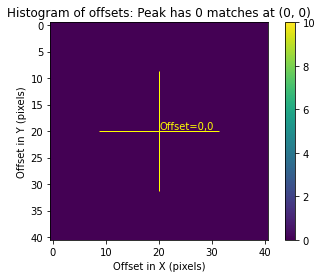

In [7]:
tweakreg.TweakReg('j8up02*flt.fits', updatehdr=True, reusename=True, interactive=False,
                  conv_width=3.0, threshold=300.0, peakmin=100, peakmax=10000)

### Edit this, currently copied.
This step adjusts image data values so that all images and chips appear (to AstroDrizzle) to have a single inverse sensitivity (PHOTFLAM). This can be achieved using the photeq task in Drizzlepac. This task adjusts image data so that when these data are multiplied by the same single PHOTFLAM value, the correct flux is obtained.

In [9]:
photeq.photeq(files='j8up02*flt.fits', ref_phot_ext=3, readonly=False)

***** drizzlepac.photeq started on 2022-08-01 15:25:45.118210
      Version 0.2 (06-Nov-2015)
         in any of the 'SCI', extensions of file 'j8up02vdq_flt.fits'.
         This input file will be ignored.
         in any of the 'SCI', extensions of file 'j8up02utq_flt.fits'.
         This input file will be ignored.
         in any of the 'SCI', extensions of file 'j8up02v5q_flt.fits'.
         This input file will be ignored.
         in any of the 'SCI', extensions of file 'j8up02uyq_flt.fits'.
         This input file will be ignored.
         in any of the 'SCI', extensions of file 'j8up02vbq_flt.fits'.
         This input file will be ignored.
         in any of the 'SCI', extensions of file 'j8up02v9q_flt.fits'.
         This input file will be ignored.
         in any of the 'SCI', extensions of file 'j8up02uuq_flt.fits'.
         This input file will be ignored.
         in any of the 'SCI', extensions of file 'j8up02vcq_flt.fits'.
         This input file will be ignored.
  

RuntimeError: Could not find the inverse sensitivity keyword 'PHOTFLAM' in the specified headers of the input image(s).
Cannot continue.

### Edit this, currently copied.
In the above command, we instruct photeq to "equalize" all chips of all input images using the PHOTFLAM for the WF3 chip (ref_phot_ext=3), using the first image as a reference. This reference PHOTFLAM value is reported in the log file:

REFERENCE VALUE FROM FILE: 'ua060502m_c0m.fits['SCI',1]'
REFERENCE 'PHOTFLAM' VALUE IS: 2.507987e-18
Upon the completion, photeq will not only adjust image data but also update PHOTFLAM values for all chips to this specific reference value.

In [10]:
astrodrizzle.AstroDrizzle('j8up02*flt.fits',
                          preserve=False,
                          driz_sep_bits='8,1024',
                          driz_sep_wcs=True,
                          driz_sep_scale=0.0996,
                          combine_type='median',
                          driz_cr_snr='5.5 3.5',
                          driz_cr_scale='2.0 1.5',
                          final_fillval=None,
                          final_bits='8,1024',
                          final_wcs=True,
                          final_scale=0.0996)

Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 3.1.8 (2020-07-27 10:34:52 -0400) started at: 15:25:59.337 (01/08/2022)

==== Processing Step  Initialization  started at  15:25:59.341 (01/08/2022)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 83.81914675198313  -5.390026960791465  
CRPIX : 533.3795180722892  520.8293172690763  
CD1_1 CD1_2  : -1.851293165171373e-05  2.0560053650305003e-05  
CD2_1 CD2_2  : 2.0560053650305003e-05  1.851293165171373e-05  
NAXIS : 1066  1041
********************************************************************************
*
*  Estimated memory usage:  up to 357 Mb.
*  Output image size:       1066 X 1041 pixels. 
*  Output image file:       ~ 12 Mb. 
*  Cores available:         8
*
********************************************************************************
==== Processing Step Initialization finished at 15:26:01.068 (01/08/2022)
==== Processing Step  Static Mask  started at  15:26:01.070 (01/08/2022)

==== Pr

   *   Image:   'j8up02vdq_flt.fits['SCI',1]'  --  SKY = 2906.4270833333326 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 1089.91   NEW MDRIZSKY = 1089.91
***** skymatch ended on 2022-08-01 15:26:05.079425
TOTAL RUN TIME: 0:00:02.439467
==== Processing Step Subtract Sky finished at 15:26:05.66 (01/08/2022)
==== Processing Step  Separate Drizzle  started at  15:26:05.66 (01/08/2022)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 83.81914675198313  -5.390026960791465  
CRPIX : 533.3795180722892  520.8293172690763  
CD1_1 CD1_2  : -1.851293165171373e-05  2.0560053650305003e-05  
CD2_1 CD2_2  : 2.0560053650305003e-05  1.851293165171373e-05  
NAXIS : 1066  1041
-Generating simple FITS output: j8up02usq_single_sci.fits
-Generating simple FITS output: j8up02v5q_single_sci.fits
-Generating simple FITS output: j8up02uyq_single_sci.fits
-Generating simple FITS output: j8up02uvq_single_sci.fits
-Generating simple FITS o

Writing out image to disk: final_drz_sci.fits
Writing out image to disk: final_drz_wht.fits
Writing out image to disk: final_drz_ctx.fits
==== Processing Step Final Drizzle finished at 15:26:33.01 (01/08/2022)

AstroDrizzle Version 3.1.8 is finished processing at 15:26:33.016 (01/08/2022).



   --------------------          --------------------
                   Step          Elapsed time
   --------------------          --------------------

         Initialization          1.7275 sec.
            Static Mask          1.2576 sec.
           Subtract Sky          3.3307 sec.
       Separate Drizzle          3.2002 sec.
          Create Median          1.7983 sec.
                   Blot          6.5511 sec.
                Driz_CR          4.8560 sec.
          Final Drizzle          10.9065 sec.
   ====================          ====================
                  Total          33.6279 sec.

Trailer file written to:  astrodrizzle.log


Finally, we visualize our beautiful combined image!

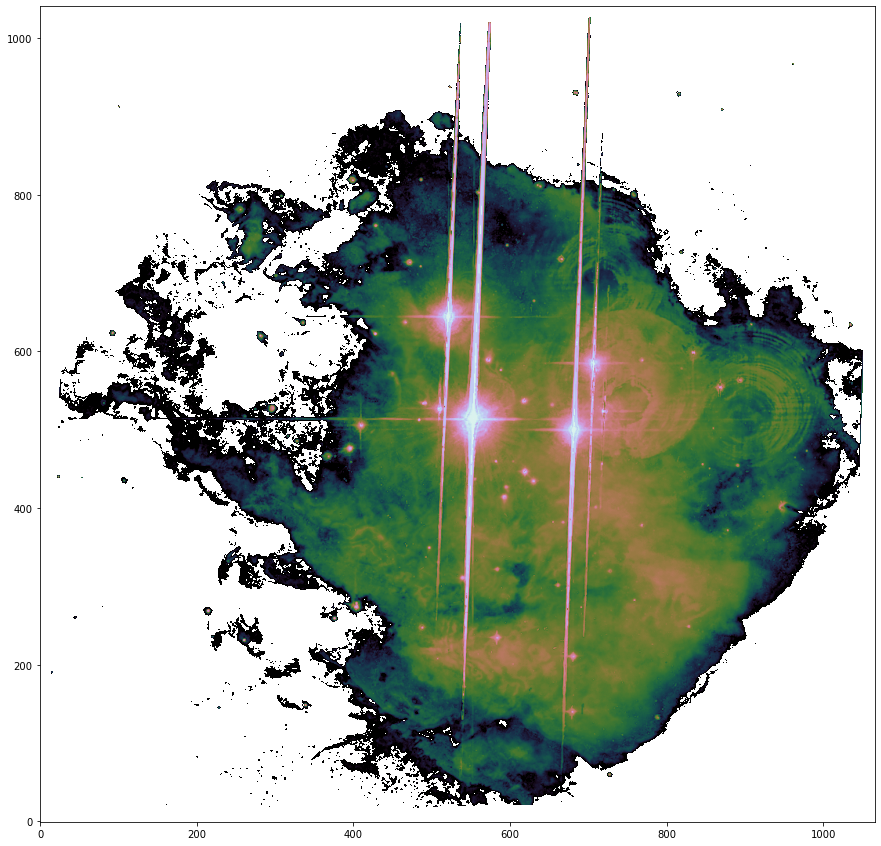

In [20]:
from matplotlib import colors
drz = fits.getdata('final_drz_sci.fits')
plt.figure(figsize=(15, 15))
drz.min(), np.nanmax(drz), drz[drz>0].min()
plt.imshow(drz, cmap='cubehelix',norm = colors.LogNorm(1,3e3), origin='lower')

For more complex cases, see: 
    notebooks/DrizzlePac/use_ds9_regions_in_tweakreg

### Assignment 2
Inspect the header file. What else can you learn about the observation and its processing from this? How many files were combined? Were these in the same, or different filters? What inputs were provided to AstroDrizzle?

### Stacking images with tweakreg


***

## Exercises
Exercises are optional, but encouraged. Exercises can be woven into the main content of your tutorial, or appear in their own section toward the end of the tutorial. Final exercises can be more challenging, similar to homework problems. They can be minimal or take as long as 30 minutes to an hour to complete. If you do have one or more exercises in your tutorial, be sure to leave a blank code cell underneath each to show the reader that they're meant to try out their new skill right there. You may also want to include a "solutions" notebook next to your main notebook for the reader to check their work after they have finished their attempt.

## Additional Resources

This section is optional. Try to weave resource links into the main content of your tutorial so that they are falling in line with the context of your writing. For resources that do not fit cleanly into your narrative, you may include an additional resources section at the end of your tutorial. Usually a list of links using Markdown bullet list plus link format is appropriate:

- [MAST API](https://mast.stsci.edu/api/v0/index.html)
- [Kepler Archive Page (MAST)](https://archive.stsci.edu/kepler/)
- [Kepler Archive Manual](https://archive.stsci.edu/kepler/manuals/archive_manual.pdf)
- [Exo.MAST website](https://exo.mast.stsci.edu/)

## About this Notebook

**Author:** Urmila Chadayammuri, Postdoctoral Fellow, Smithsonian Astrophysical Observatory

**Updated On:** 2022-07-24

## Citations
Provide your reader with guidelines on how to cite open source software and other resources in their own published work.

```
If you use `astropy` or `lightkurve` for published research, please cite the
authors. Follow these links for more information about citing `astropy` and
`lightkurve`:

* [Citing `astropy`](https://www.astropy.org/acknowledging.html)
* [Citing `lightkurve`](http://docs.lightkurve.org/about/citing.html)

```

***

[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 